In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import statsmodels.api as sm
from scipy.linalg import sqrtm
import ot

In [2]:
def wasserstein_gaussian_square(mu1, sigma1, mu2, sigma2):
    """
    Compute the 2-Wasserstein distance between two Gaussian distributions.

    Parameters:
    - mu1, mu2: Mean vectors (shape: [d])
    - sigma1, sigma2: Covariance matrices (shape: [d, d])

    Returns:
    - W2_distance: The 2-Wasserstein distance
    """
    # Ensure inputs are arrays
    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)
    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    # Compute the squared Euclidean distance between the means
    mean_diff = mu1 - mu2
    mean_norm = np.dot(mean_diff, mean_diff)

    # Compute the matrix square roots
    sigma1_sqrt = sqrtm(sigma1)

    # Compute the product sigma1_sqrt * sigma2 * sigma1_sqrt
    sigma1_sqrt_sigma2_sigma1_sqrt = sigma1_sqrt @ sigma2 @ sigma1_sqrt

    # Compute the square root of the product matrix
    cov_mean = sqrtm(sigma1_sqrt_sigma2_sigma1_sqrt)

    # Handle numerical errors (if any imaginary parts due to computation)
    if np.iscomplexobj(cov_mean):
        cov_mean = cov_mean.real

    # Compute the trace term
    trace_term = np.trace(sigma1 + sigma2 - 2 * cov_mean)

    # Compute the squared Wasserstein-2 distance
    W2_squared = mean_norm + trace_term

    # # Return the Wasserstein-2 distance
    # W2_distance = np.sqrt(W2_squared)

    return W2_squared
    # return W2_distance


In [3]:
seed = 1
n = 1000
d = 10

# Generate A1, A2, B1, B2
# X ~ N(0, I), Y ~ N(0, I)
# Y1 = A1 X + B1, Y2 = A2 X + B2

np.random.seed(seed)
A1_vector = np.random.normal(0, 1, d)
A2_vector = np.random.normal(0, 1, d)
A1 = np.diag(A1_vector)
A2 = np.diag(A2_vector)

B1 = np.random.normal(0, 1, d)
B2 = np.random.normal(0, 1, d)


In [4]:
mu = np.zeros(d)
sigma = np.diag(np.ones(d))

dist = -wasserstein_gaussian_square(mu, sigma, B1, np.power(A1, 2)) + wasserstein_gaussian_square(mu, sigma, B2, np.power(A2, 2))
print(dist)

0.6475600669219865


In [5]:
estimator_list = []
for seed in range(1000):
    if seed % 50 == 0:
        print(seed)
    np.random.seed(seed)
    X = np.random.normal(0, 1, (n, d))

    Y1 = X * A1_vector + B1
    Y2 = X * A2_vector + B2

    Y = np.random.normal(0, 1, (n, d))

    weights = np.ones(n) / n
    weights1 = np.ones(n) / n
    weights2 = np.ones(n) / n

    M1 = ot.dist(Y, Y1, metric='euclidean') ** 2
    M2 = ot.dist(Y, Y2, metric='euclidean') ** 2

    transport_plan1 = ot.emd(weights, weights1, M1)
    W2_distance_squared1 = np.sum(transport_plan1 * M1)

    transport_plan2 = ot.emd(weights, weights2, M2)
    W2_distance_squared2 = np.sum(transport_plan2 * M2)

    estimator_list.append(W2_distance_squared2 - W2_distance_squared1)




0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950


In [8]:
dist

0.6475600669219865

In [7]:
np.mean(estimator_list)

-0.36170422802702923

(array([  1.,   5.,  39.,  93., 220., 247., 215., 130.,  39.,  11.]),
 array([-1.81313251, -1.55326205, -1.2933916 , -1.03352115, -0.7736507 ,
        -0.51378024, -0.25390979,  0.00596066,  0.26583111,  0.52570157,
         0.78557202]),
 <BarContainer object of 10 artists>)

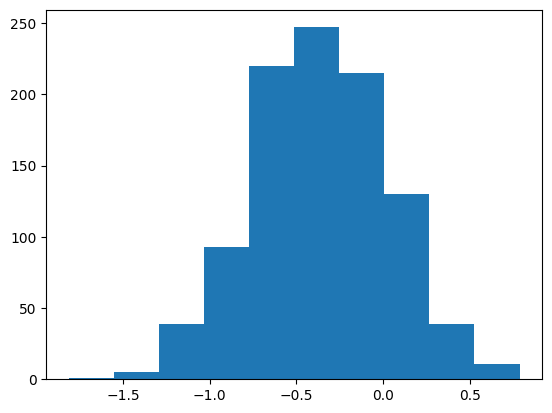

In [6]:
plt.hist(estimator_list)